## Plotting HI power spectrum, low-k constant piece, $P_{\rm err}$, and different versions of thermal noise

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import revelant packages
from FishLSS.headers import *
from FishLSS.twoPoint import *
from FishLSS.twoPointNoise import *
import FishLSS.parameter_forecast as pf

In [3]:
# Get default matplotlib color cycle, so that we can repeat colors easily in plots
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [4]:
out_dir = {
    "chordnoise": "../output/specderivs/pkplot_chordnoise/",
    "cvnoise": "../output/specderivs/pkplot_cvnoise/",
}

fc_names = [
    "puma_32k_opt", 
    "puma_5k_opt", 
    "chord_opt", 
]

In [5]:
fc = {}
for n in out_dir.keys():
    for name in fc_names:
        print(f"** Loading {n}, {name}")
        fc[n, name, "withnoise"] = pf.load_forecast(name, verbose=False, out_root_dir=out_dir[n] + "withnoise/")
        if name == "puma_32k_opt":
            fc[n, name, "nothermalnoise"] = pf.load_forecast(name, verbose=False, out_root_dir=out_dir[n] + "nothermalnoise/")
            fc[n, name, "nonoise"] = pf.load_forecast(name, verbose=False, out_root_dir=out_dir[n] + "nonoise/")

** Loading chordnoise, puma_32k_opt
** Loading chordnoise, puma_5k_opt
** Loading chordnoise, chord_opt
** Loading cvnoise, puma_32k_opt
** Loading cvnoise, puma_5k_opt
** Loading cvnoise, chord_opt


## Power spectrum plots

In [6]:
fc_withnoise = {}
fc_nothermalnoise = {}
fc_nonoise = {}

for n in out_dir.keys():
    fc_withnoise[n] = fc[n,"puma_32k_opt", "withnoise"]
    fc_nothermalnoise[n] = fc[n, "puma_32k_opt", "nothermalnoise"]
    fc_nonoise[n] = fc[n, "puma_32k_opt", "nonoise"]
    
    k_shape = (fc_nonoise[n]['forecast'].Nk, fc_nonoise[n]['forecast'].Nmu)
    k_for_plot = fc_nonoise[n]['forecast'].k.reshape(k_shape)[:, 0]
    mu = fc_nonoise[n]['forecast'].mu.reshape(k_shape)[0]

print(f"Saved z values: {fc_nonoise[n]['Centers of redshift bins']}")

Saved z values: [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [7]:
z_for_plot = [0.5, 1, 1.5, 2, 3, 4, 5]
zi_for_plot = [0, 1, 2, 3, 5, 7, 9]

In [8]:
def plot_spectra(n):
    nx = 4
    ny = 2

    fig, ax = plt.subplots(ny, nx, figsize=(9, 4.5), sharex=True, sharey=True)

    for axi, (zi, z) in enumerate(zip(zi_for_plot, z_for_plot)):
        ax_ = ax.flatten()[axi]

        pHI_mu0 = fc_nonoise[n]['forecast'].P_fid_for_cov[zi].reshape(k_shape)[:, mu == 0]
        pHI_lowk_constant = (
            fc_nothermalnoise[n]['forecast'].P_fid_for_cov[zi] - fc_nothermalnoise[n]['forecast'].P_fid[zi]
        ).reshape(k_shape)[:, 0]
        pHI_stoch = np.ones_like(k_for_plot) * fc_nothermalnoise[n]['exp'].Pstoch_HI(z)

        puma32k_noise = HI_therm(fc[n, "puma_32k_opt", "withnoise"]['forecast'], z)(k_for_plot, 0.)
        puma32k_mask = puma32k_noise > 0

        puma5k_noise = HI_therm(fc[n, "puma_5k_opt", "withnoise"]['forecast'], z)(k_for_plot, 0.)
        puma5k_mask = puma5k_noise > 0

        chord_noise = HI_therm(fc[n, "chord_opt", "withnoise"]['forecast'], z)(k_for_plot, 0.)
        chord_mask = chord_noise > 0

        ax_.plot(k_for_plot, np.abs(pHI_mu0), c='k', label=r"$P_{\rm HI}$")
        ax_.plot(k_for_plot, pHI_lowk_constant, ls='-.', label=r"$P_{{\rm stoch}, {\rm NL}}$")
        ax_.plot(k_for_plot, pHI_stoch, ls='--', dashes=(10, 2), label=r"$P_{\rm err}$")

        ax_.plot(k_for_plot[puma32k_mask], puma32k_noise[puma32k_mask], ls='--', alpha=0.5, label=r"$P_{\rm N}$: PUMA-32k")
        ax_.plot(k_for_plot[puma5k_mask], puma5k_noise[puma5k_mask], ls='--', alpha=0.5, label=r"$P_{\rm N}$: PUMA-5k")
        if z < 3.7:
            ax_.plot(k_for_plot[chord_mask], chord_noise[chord_mask], ls='--', alpha=0.5, label=r"$P_{\rm N}$: CHORD")

        ax_.set_xlim(0.01, 3)
        ax_.set_ylim(1e0, 2e4)
        ax_.set_xscale('log')
        ax_.set_yscale('log')
        ax_.grid(ls='--')
        # ax_.set_yticks(np.geomspace(1e0, 1e4, 5))

        # ax_.set_title(rf"$z = {z}$")
        ax_.text(0.0135, 2, rf"$z = {z}$", backgroundcolor="white", fontsize=11)

    ax[-1, -1].axis('off')

    for i in range(ny):
        ax[i, 0].set_ylabel(r'$P(k, \mu=0)\;[h^{-3}\,{\rm Mpc}^3]$')

    for i in range(nx):
        ax[ny-1, i].set_xlabel(r'$k_\perp\;[h\,{\rm Mpc}^{-1}]$')
    # ax[0, -1].set_xlabel(r'$k\;[h\,{\rm Mpc}^{-1}]$')


    handles, labels = ax[0, nx-1].get_legend_handles_labels()
    ax[-1, -1].legend(handles, labels, loc='center')

    plt.tight_layout()

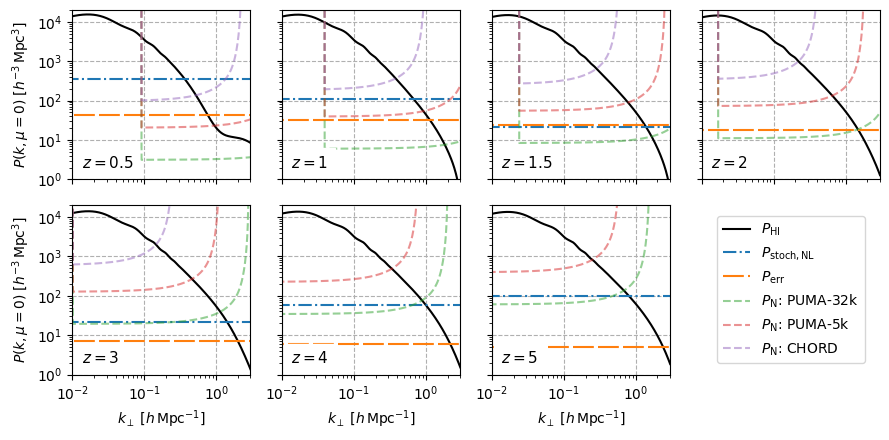

In [9]:
plot_spectra("chordnoise")
plt.savefig("../plots/paper/power_spectra_chordnoise.pdf")

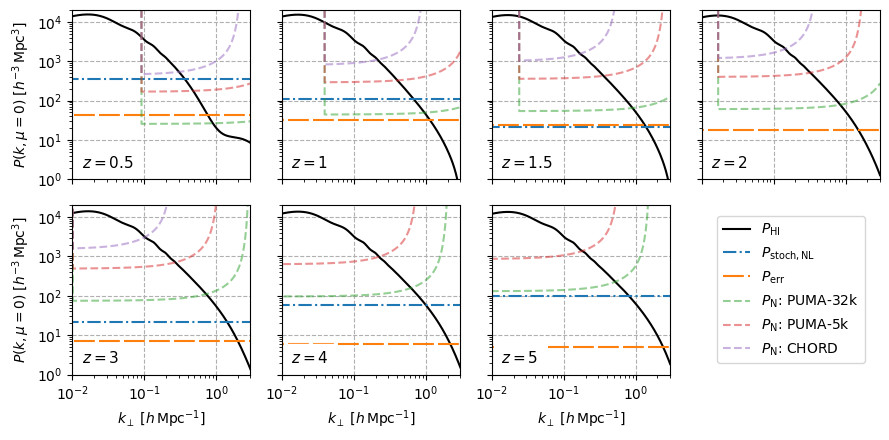

In [10]:
plot_spectra("cvnoise")
plt.savefig("../plots/paper/power_spectra_cvnoise.pdf")

## Comparing $P_{\rm stoch,NL}(z)$ with fitting function for $P_{\rm stoch}^{(k\to 0)}(z)$

In [11]:
Pstoch_meas_data = np.loadtxt("../input_files/obuljen/TNG_z_meanPstoch_stdPstoch_kmax=0.16.txt")[1:]
Perr_meas_data = np.loadtxt("../input_files/obuljen/TNG_z_meanPerr_stdPerr_kmin0.1_kmax0.3.txt")[1:]

In [12]:
z_lowk = np.array([0.5, 1, 1.5, 2, 3, 5])
zi_lowk = [0, 1, 2, 3, 5, 9]

Pstoch_from_PT = np.array(
    [(fc_nothermalnoise[n]['forecast'].P_fid_for_cov[zi] - fc_nothermalnoise[n]['forecast'].P_fid[zi])[0] for zi in zi_lowk]
)

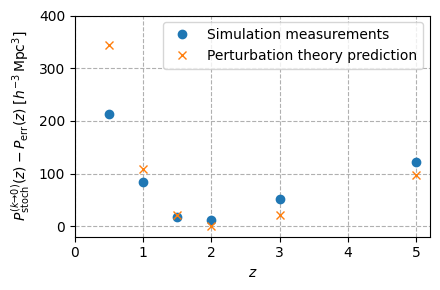

In [13]:
fig, ax_ = plt.subplots(1, 1, figsize=(4.5, 3))
ax = [ax_]

ax[0].plot(
    Pstoch_meas_data[:, 0], 
    Pstoch_meas_data[:, 1] - Perr_meas_data[:, 1],
    'o', 
    c=colors[0], 
    label=r"Simulation measurements"
)
ax[0].plot(z_lowk, Pstoch_from_PT, 'x', c=colors[1], label=r"Perturbation theory prediction")

ax[0].grid(ls='--')
ax[0].set_ylabel(r"$P_{\rm stoch}^{(k\to 0)}(z) - P_{\rm err}(z)\;[h^{-3}\,{\rm Mpc}^3]$")
ax[0].legend()
ax[0].set_xlim(0, 5.2)
ax[0].set_ylim(-20, 400)
ax[0].set_xlabel(r"$z$")

plt.tight_layout()
plt.savefig("../plots/paper/stoch_comparison.pdf")